<h1 align='center' style='color:black'>  Pink Cab vs Yellow Cab  </h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imoprting the Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the Data


In [48]:
data = pd.read_csv('/content/drive/MyDrive/ Final_Data.csv', parse_dates=['Date of Travel'])


In [49]:
data=data.set_index('Date of Travel')

In [50]:
Pink = data['Profit'].loc[data['Company'] == 'Pink Cab']
Yellow = data['Profit'].loc[data['Company'] == 'Yellow Cab']
print('The Shape of Pink Cab is:',Pink.shape,'\n','The Shape of Yellow Cab is:',Yellow.shape)

The Shape of Pink Cab is: (84711,) 
 The Shape of Yellow Cab is: (274681,)


## Data Exploration

In [51]:
Pink=Pink.reset_index()
Yellow=Yellow.reset_index()
# Combine two data frames into one
Pink = Pink.sort_values('Date of Travel')
Yellow = Yellow.sort_values('Date of Travel')
Pink = Pink.groupby('Date of Travel')['Profit'].sum().reset_index()
Yellow = Yellow.groupby('Date of Travel')['Profit'].sum().reset_index()
Pink = Pink.set_index('Date of Travel')
Yellow = Yellow.set_index('Date of Travel')
y_Pink = Pink['Profit'].resample('MS').mean()
y_Yellow = Yellow['Profit'].resample('MS').mean()
Pink = pd.DataFrame({'Date of Travel':y_Pink.index, 'Profit':y_Pink.values})
Yellow = pd.DataFrame({'Date of Travel': y_Yellow.index, 'Profit': y_Yellow.values})
store = Pink.merge(Yellow, how='inner', on='Date of Travel')
store.rename(columns={'Profit_x': 'Pink_Profit', 'Profit_y': 'Yellow_Profit'}, inplace=True)
store.head()

,Date of Travel,Pink_Profit,Yellow_Profit
0,2016-01-01,2454.600000,27816.100000
1,2016-02-01,3002.034483,34719.620690
2,2016-03-01,2816.000000,29433.483871
3,2016-04-01,2737.266667,31453.800000
4,2016-05-01,1972.967742,41288.483871


## Visualizing Profit Time Series Data

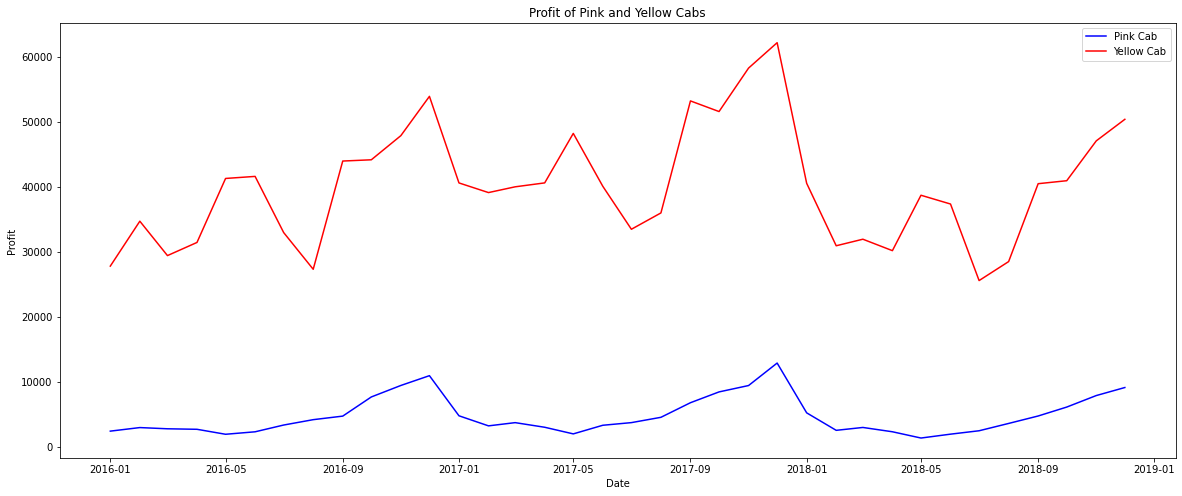

In [52]:
plt.figure(figsize=(20, 8))
plt.plot(store['Date of Travel'], store['Pink_Profit'], 'b-', label = 'Pink Cab')
plt.plot(store['Date of Travel'], store['Yellow_Profit'], 'r-', label = 'Yellow Cab')
plt.xlabel('Date'); plt.ylabel('Profit'); plt.title('Profit of Pink and Yellow Cabs')
plt.legend();

### Inference :
- We observe that profits of pink and yellow cabs have a different seasonal pattern.
- in addition, average daily profits for yellow cabs are higher than those of pink cabs in most of the months.

## Time Series Modeling with Prophet

## 1. Pink Cab

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Pink Cab Profits')

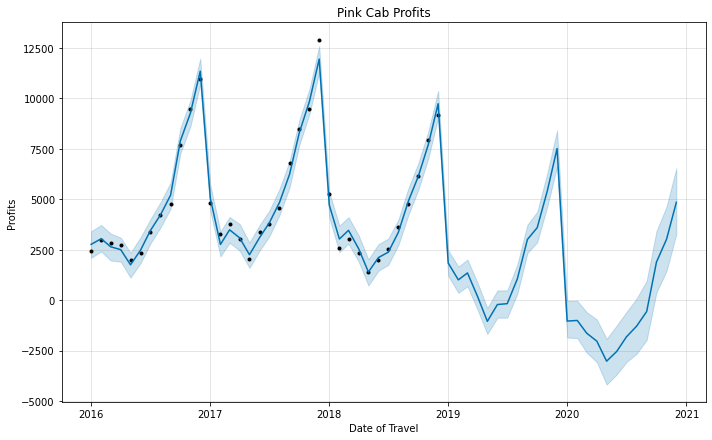

In [53]:
 from fbprophet import Prophet
#Training the model
Pink = Pink.rename(columns={'Date of Travel': 'ds', 'Profit': 'y'})
Pink_model = Prophet(interval_width=0.95)
Pink_model.fit(Pink)

# Forecasts for two years for pink cab into the future
Pink_forecast = Pink_model.make_future_dataframe(periods=24, freq='MS')
Pink_forecast = Pink_model.predict(Pink_forecast)

# Plotting the Forecasts
Pink_model.plot(Pink_forecast, xlabel = 'Date of Travel', ylabel = 'Profits')
plt.title('Pink Cab Profits')


## 2. Yellow Cab

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Yellow Cabs Profits')

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

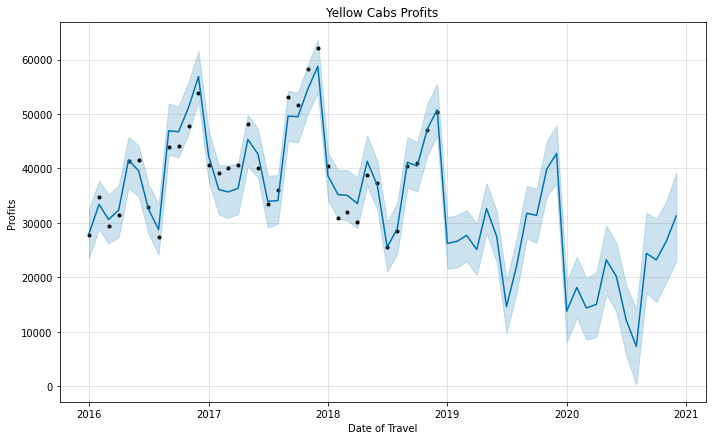

In [54]:
# Training the model
Yellow = Yellow.rename(columns={'Date of Travel': 'ds', 'Profit': 'y'})
Yellow_model = Prophet(interval_width=0.95)
Yellow_model.fit(Yellow)

# forecasts for two years for yellow cab into the future
Yellow_forecast = Yellow_model.make_future_dataframe(periods=24, freq='MS')
Yellow_forecast = Yellow_model.predict(Yellow_forecast)
plt.figure(figsize=(18, 6))

# Plotting the forecasts
plt.figure(figsize=(18, 6))
Yellow_model.plot(Yellow_forecast, xlabel = 'Date of Travel', ylabel = 'Profits')
plt.title('Yellow Cabs Profits')

## Compare Forecasts

In [55]:
# We will now join them together to compare their future forecasts
Pink_names = ['Pink_%s' % column for column in Pink_forecast.columns]
Yellow_names = ['Yellow_%s' % column for column in Yellow_forecast.columns]
merge_Pink_forecast = Pink_forecast.copy()
merge_Yellow_forecast = Yellow_forecast.copy()
merge_Pink_forecast.columns = Pink_names
merge_Yellow_forecast.columns = Yellow_names
forecast = pd.merge(merge_Pink_forecast, merge_Yellow_forecast, how = 'inner', 
                    left_on = 'Pink_ds', right_on = 'Yellow_ds')
forecast = forecast.rename(columns={'Pink_ds': 'Date of Travel'}).drop('Yellow_ds', axis=1)
forecast.tail()

,Date of Travel,Pink_trend,Pink_yhat_lower,Pink_yhat_upper,Pink_trend_lower,Pink_trend_upper,Pink_additive_terms,Pink_additive_terms_lower,Pink_additive_terms_upper,Pink_yearly,Pink_yearly_lower,Pink_yearly_upper,Pink_multiplicative_terms,Pink_multiplicative_terms_lower,Pink_multiplicative_terms_upper,Pink_yhat,Yellow_trend,Yellow_yhat_lower,Yellow_yhat_upper,Yellow_trend_lower,Yellow_trend_upper,Yellow_additive_terms,Yellow_additive_terms_lower,Yellow_additive_terms_upper,Yellow_yearly,Yellow_yearly_lower,Yellow_yearly_upper,Yellow_multiplicative_terms,Yellow_multiplicative_terms_lower,Yellow_multiplicative_terms_upper,Yellow_yhat
55,2020-08-01,-572.035488,-2658.011669,80.214674,-1698.286228,630.491933,-718.515558,-718.515558,-718.515558,-718.515558,-718.515558,-718.515558,0.0,0.0,0.0,-1290.551046,18321.360774,323.817103,14174.787410,13126.473924,23831.851578,-10993.404942,-10993.404942,-10993.404942,-10993.404942,-10993.404942,-10993.404942,0.0,0.0,0.0,7327.955832
56,2020-09-01,-769.595811,-1969.984583,963.450618,-1959.706019,517.892831,206.711685,206.711685,206.711685,206.711685,206.711685,206.711685,0.0,0.0,0.0,-562.884126,17570.789236,17157.251411,31904.388285,11967.189152,23407.270134,6843.473371,6843.473371,6843.473371,6843.473371,6843.473371,6843.473371,0.0,0.0,0.0,24414.262607
57,2020-10-01,-960.783220,388.056651,3423.883905,-2241.423569,425.923673,2848.424490,2848.424490,2848.424490,2848.424490,2848.424490,2848.424490,0.0,0.0,0.0,1887.641270,16844.429682,15494.683849,30737.895959,10869.397436,22981.778449,6373.984497,6373.984497,6373.984497,6373.984497,6373.984497,6373.984497,0.0,0.0,0.0,23218.414179
58,2020-11-01,-1158.343542,1450.348379,4648.509353,-2516.140607,328.763127,4180.766509,4180.766509,4180.766509,4180.766509,4180.766509,4180.766509,0.0,0.0,0.0,3022.422967,16093.858144,19144.583310,33948.944006,9695.865602,22574.042689,10583.339987,10583.339987,10583.339987,10583.339987,10583.339987,10583.339987,0.0,0.0,0.0,26677.198131
59,2020-12-01,-1349.530951,3276.858082,6542.635296,-2826.197396,233.606267,6200.341193,6200.341193,6200.341193,6200.341193,6200.341193,6200.341193,0.0,0.0,0.0,4850.810242,15367.498590,23018.211948,39280.461635,8640.947120,22313.453818,15910.162211,15910.162211,15910.162211,15910.162211,15910.162211,15910.162211,0.0,0.0,0.0,31277.660801


In [56]:
# Printing the predicted values for both cabs
forecast[['Pink_yhat', 'Yellow_yhat']].tail()

,Pink_yhat,Yellow_yhat
55,-1290.551046,7327.955832
56,-562.884126,24414.262607
57,1887.641270,23218.414179
58,3022.422967,26677.198131
59,4850.810242,31277.660801


## Trend Visualization

Text(0.5, 1.0, 'Pink Cab vs. Yellow Cab Profits Trend')

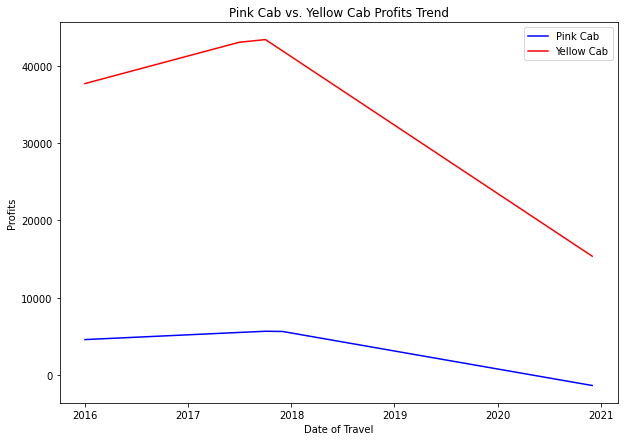

In [58]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date of Travel'], forecast['Pink_trend'], 'b-',label='Pink Cab')
plt.plot(forecast['Date of Travel'], forecast['Yellow_trend'], 'r-', label='Yellow Cab')
plt.legend(); plt.xlabel('Date of Travel')
plt.ylabel('Profits')
plt.title('Pink Cab vs. Yellow Cab Profits Trend')

## Forecast Visualization

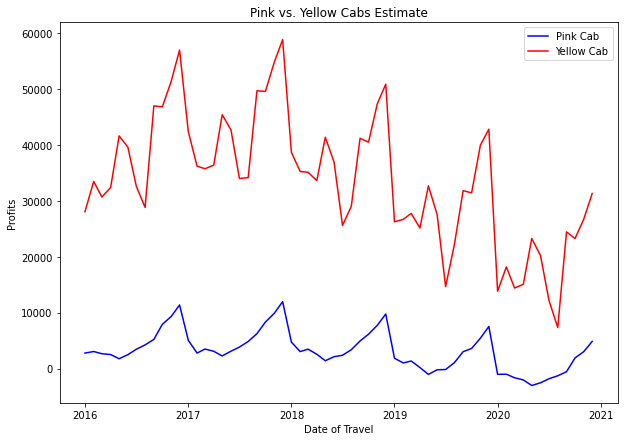

In [59]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date of Travel'], forecast['Pink_yhat'], 'b-', label='Pink Cab')
plt.plot(forecast['Date of Travel'], forecast['Yellow_yhat'], 'r-', label='Yellow Cab')
plt.legend()
plt.xlabel('Date of Travel'); plt.ylabel('Profits')
plt.title('Pink vs. Yellow Cabs Estimate');

## Trends and Patterns

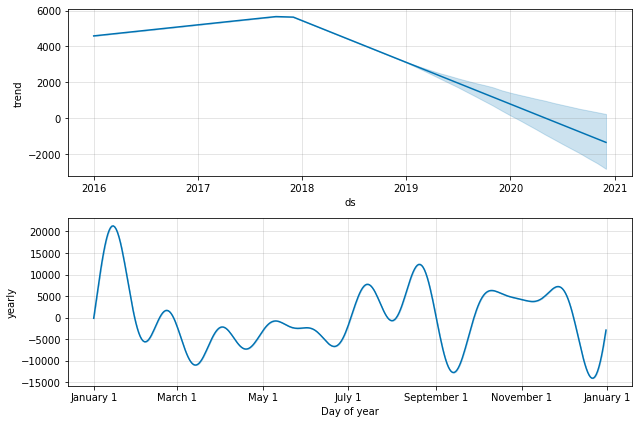

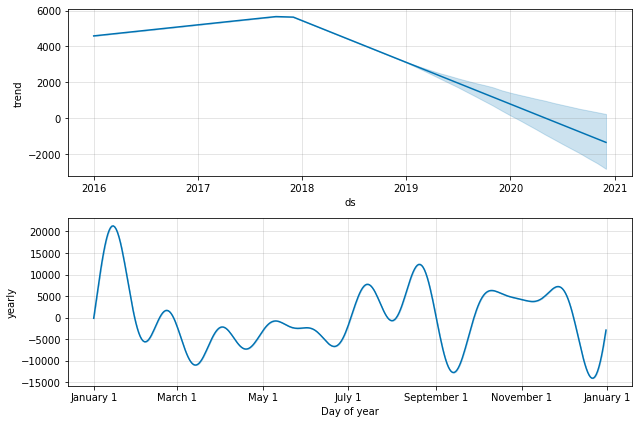

In [60]:
# we can use the Prophet Models to inspect different trends of these two categories in the data
Pink_model.plot_components(Pink_forecast)

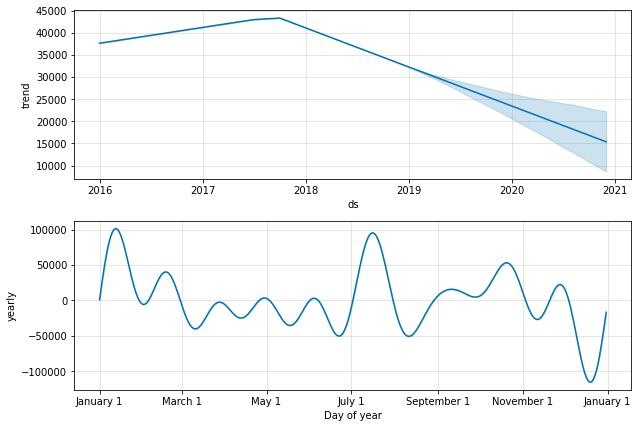

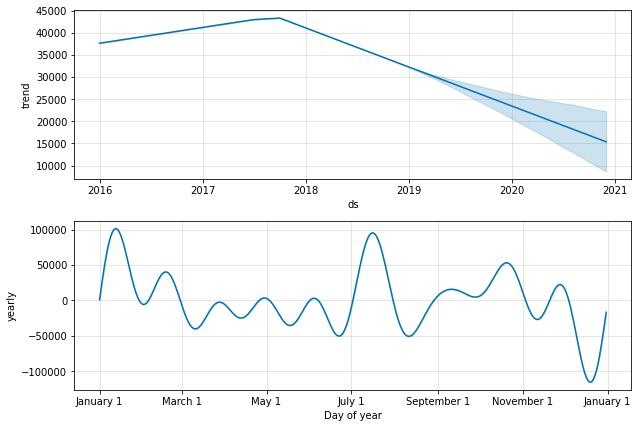

In [61]:
Yellow_model.plot_components(Yellow_forecast)

### Inference :
- Bad to see that the Profits for both Pink and Yellow Cabs have been linearly decreasing over time and will be keep down.

- The best month for both Cabs is  January, and the worst month is December.

### The Mean Squared Error of our forecasts

## 1. Pink Cab

In [62]:
p_actual= store['Pink_Profit']
p1_forecast= forecast.iloc[24:36]
p2_forecast= p1_forecast['Pink_yhat']
p_mse = ((p2_forecast - p_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(p_mse, 2)))

The Mean Squared Error of our forecasts is 104119.3


## 2. Yellow Cab

In [63]:
y_actual= store['Yellow_Profit']
y1_forecast= forecast.iloc[24:36]
y2_forecast= y1_forecast['Yellow_yhat']
y_mse = ((y2_forecast - y_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(y_mse, 2)))

The Mean Squared Error of our forecasts is 4245330.8


### The Root Mean Squared Error of our forecasts

## 1. Pink Cab

In [64]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(p_mse), 2)))

The Root Mean Squared Error of our forecasts is 322.68


## 2. Yellow Cab

In [65]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(y_mse), 2)))

The Root Mean Squared Error of our forecasts is 2060.42


## Saving Pink Cab Model

In [70]:
import joblib
joblib.dump(Pink_model, 'pink_mod.pkl') 

['pink_mod.pkl']

## Saving Yellow Cab Model

In [71]:
import joblib
joblib.dump(Yellow_model, 'yellow_mod.pkl') 

['yellow_mod.pkl']